***Exercice 1 : Question 2***

In [621]:
# 
import numpy as np
import pandas as pd
from dateutil.parser import ParserError
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from math import log2
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
from sklearn import datasets
from sklearn.metrics import accuracy_score, precision_score, recall_score


In [622]:
# chargement du dataset avec pandas
data = pd.read_csv('heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [624]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [625]:
# Fonction qui permet de transformer les données non réelles en données réelles (object en int ou float)
def transform_data(data):
    label_encoder = LabelEncoder()
    list_features = list(data.columns)
    categorical = []
    numerical = []

    for i in list_features:
        if len(data[i].unique())>5: 
                numerical.append(i)
        else:
                categorical.append(i)

    for i in categorical :
        data[i]=label_encoder.fit_transform(data[i])

In [626]:
transform_data(data)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    int64  
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 86.2 KB


In [627]:
# Fonction qui renvoie les attributs et les target
def get_data(_data, target_column):
    y = np.array(_data[target_column])
    X = list()
    for feature in list(_data.columns):
        X.append(list(_data[feature]))
    X  = np.array(X[:-1]).T
    return X, y


In [633]:
class MyLDA:
    def __init__(self):
        self.X = None
        self.y = None
        self.mean_class = {}
        self.class_covariance = {}
        self.covariance_matrix = None

    def fit(self, _X, _y):
        # calcule la matrice de covariance pour l'ensemble de données fournie avec les entrées X et y, 
        # ainsi que les moyennes de classe pour chaque classe unique dans y.

        self.X = _X
        self.y = _y

        self.covariance_matrix = np.cov(_X, rowvar=False)
        unique_classes = np.unique(self.y)

        for c in unique_classes:
            class_samples = _X[_y == c]
            self.mean_class[c] = np.mean(class_samples, axis=0)

        for c in unique_classes:
            class_samples = _X[_y == c]
            self.class_covariance[c] = np.cov(class_samples, rowvar=False)


    def predict(self, test_data):
        # renvoie les prédictions de classe pour chaque échantillon en utilisant le modèle de LDA formé avec "fit"
        inverse_covariance_matrix = np.linalg.inv(self.covariance_matrix)
        res = list()
        
        for line in test_data:
            deltas = list()
            classes = list()
            for m_class in self.mean_class:
                mean_c = self.mean_class[m_class]
                pi_k = len(self.X[self.y==m_class])/len(self.X)
                # Formule de calcul de probabilité vue au cours
                delta = np.dot(np.dot(line.T,inverse_covariance_matrix), mean_c) - 1/2 * np.dot(np.dot(mean_c.T,inverse_covariance_matrix), mean_c) + log2(pi_k)
                deltas.append(delta)
                classes.append(m_class)
            index = deltas.index(max(deltas))
            res.append(classes[index])

        return np.array(res)


In [634]:

def plot_confusion_matrix(y_test, prediction, title="Confusion Matrix LDA"):
    # plot une matrice de confusion
    c_matrix = confusion_matrix(y_test, prediction)
    cm_df = pd.DataFrame(c_matrix)
    plt.figure(figsize=(8,6))
    
    sns.heatmap(cm_df, annot=True, fmt='d', cmap=plt.cm.Greens)

    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [635]:

def illustrate_result(X, y):
    # Illustration de resultat en calculant Les metriques Accuracy, Precision & Recall
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42) 

    model = MyLDA()
    model.fit(X_train,y_train)
    res = model.predict(X_test)

    print('The accuracy: ',accuracy_score(y_test, res))
    print('The precision: ',precision_score(y_test, res, average='macro'))
    print('The recall: ',recall_score(y_test, res, average='macro'))

    plot_confusion_matrix(y_test, res)
    

The accuracy:  0.8633540372670807
The precision:  0.8576271186440678
The recall:  0.8668318612365613


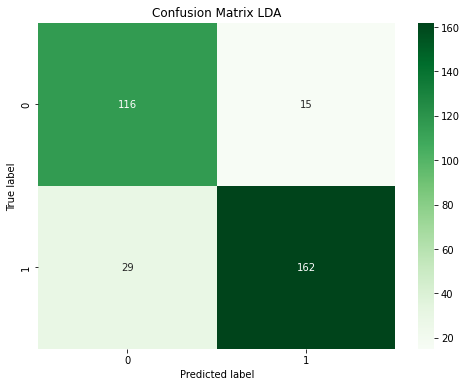

In [636]:
# on teste notre modèle sur le data set de heart.csv

X, y = get_data(data, 'HeartDisease')

illustrate_result(X,y)

The accuracy:  1.0
The precision:  1.0
The recall:  1.0


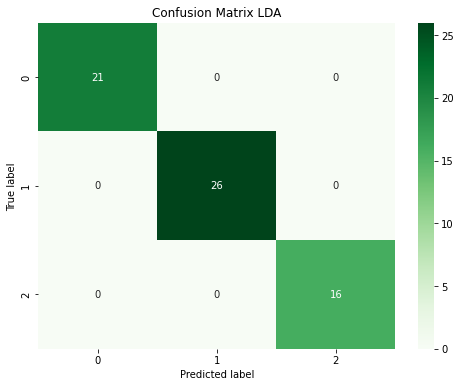

In [637]:
# Illustrons notre modèle sur le dataset wine de sklearn.datasets

wine = datasets.load_wine()
X = wine.data
y = wine.target

illustrate_result(X,y)

The accuracy:  0.92
The precision:  0.9387805177278861
The recall:  0.8904902281908504


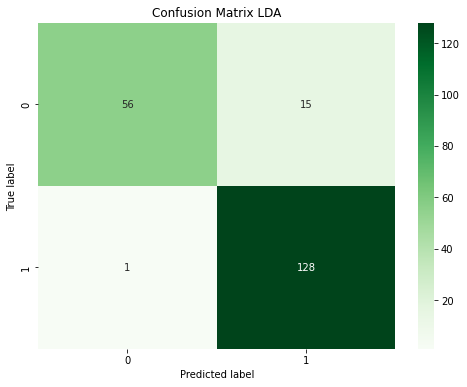

In [638]:
 # Illustrons ce que nous avons obtenu avec le dataset breast_cancer

b_cancer = datasets.load_breast_cancer()
X = b_cancer.data
y = b_cancer.target

illustrate_result(X,y)
